### Import

In [1]:
# !pip install -U numpy pandas scikit-learn matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import perf_counter

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.inspection import permutation_importance

### Plot helper

In [2]:
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

def plot_pred_vs_true(y_true, y_pred, title="Predicted vs True"):
    plt.figure(figsize=(5,5))
    plt.scatter(y_true, y_pred, s=8, alpha=0.6)
    lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
    plt.plot(lims, lims)  # y=x reference
    plt.xlabel("True")
    plt.ylabel("Predicted")
    plt.title(title)
    plt.tight_layout()
    plt.show()

def summarize(y_train, y_pred_train, y_test, y_pred_test, fit_time, label):
    print(f"=== {label} ===")
    print(f"Train R^2: {r2_score(y_train, y_pred_train):.4f}")
    print(f"Test  R^2: {r2_score(y_test,  y_pred_test):.4f}")
    print(f"Train MAE: {mean_absolute_error(y_train, y_pred_train):.4f}")
    print(f"Test  MAE: {mean_absolute_error(y_test,  y_pred_test):.4f}")
    print(f"Fit time: {fit_time*1000:.1f} ms")

## Synthetic Data

In [3]:
def make_linear(n=500, d=8, noise=0.5, rng=None):
    rng = rng or np.random.default_rng(0)
    X = rng.normal(size=(n, d))
    true_w = rng.normal(size=(d,))
    y = X @ true_w + rng.normal(scale=noise, size=n)
    return X, y, true_w

def make_nonlinear(n=1000, d=8, noise=0.5, rng=None):
    rng = rng or np.random.default_rng(1)
    X = rng.uniform(-2, 2, size=(n, d))
    # Nonlinear signal: quadratic term + interaction + sin
    y = (
        2*X[:,0]**2
        + 1.5*X[:,1]*X[:,2]
        + np.sin(2*np.pi*X[:,3])
        + 0.8*X[:,4]
        - 0.5*X[:,5]
    )
    y += rng.normal(scale=noise, size=n)
    return X, y

X_lin, y_lin, true_w = make_linear(n=800, d=10, noise=0.4, rng=rng)
X_non, y_non = make_nonlinear(n=1500, d=10, noise=0.4, rng=rng)

print("Linear dataset:", X_lin.shape, y_lin.shape)
print("Nonlinear dataset:", X_non.shape, y_non.shape)

Linear dataset: (800, 10) (800,)
Nonlinear dataset: (1500, 10) (1500,)


### Train/Test split

In [4]:
Xtr_lin, Xte_lin, ytr_lin, yte_lin = train_test_split(X_lin, y_lin, test_size=0.25, random_state=RANDOM_SEED)
Xtr_non, Xte_non, ytr_non, yte_non = train_test_split(X_non, y_non, test_size=0.25, random_state=RANDOM_SEED)

### Models pipeline

In [5]:
lr_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LinearRegression())
])

nn_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", MLPRegressor(hidden_layer_sizes=(128, 64),
                           activation="relu",
                           solver="adam",
                           max_iter=2000,
                           random_state=RANDOM_SEED,
                           early_stopping=True,
                           n_iter_no_change=20,
                           validation_fraction=0.1))
])

### Fit + Evaluate on Linear Synthetic

=== Linear Data — Linear Regression ===
Train R^2: 0.9866
Test  R^2: 0.9817
Train MAE: 0.2977
Test  MAE: 0.3447
Fit time: 26.9 ms


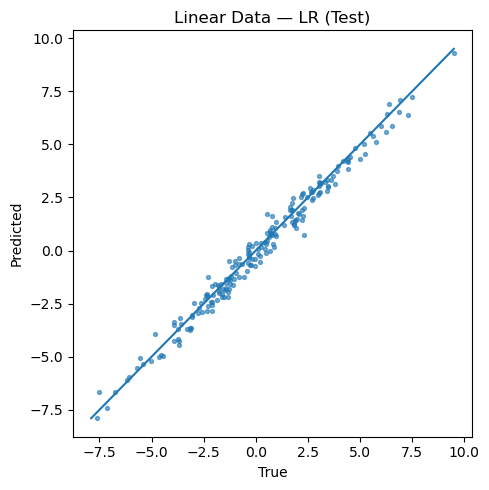

=== Linear Data — Neural Network ===
Train R^2: 0.9915
Test  R^2: 0.9761
Train MAE: 0.2335
Test  MAE: 0.3888
Fit time: 498.0 ms


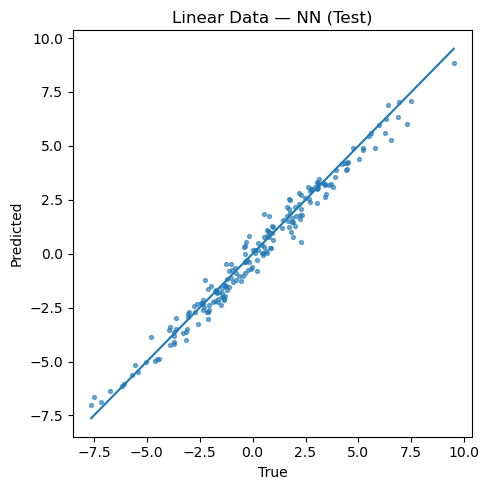

In [6]:
# Linear Regression
t0 = perf_counter()
lr_pipe.fit(Xtr_lin, ytr_lin)
t1 = perf_counter()
yhat_tr_lr = lr_pipe.predict(Xtr_lin)
yhat_te_lr = lr_pipe.predict(Xte_lin)
summarize(ytr_lin, yhat_tr_lr, yte_lin, yhat_te_lr, t1 - t0, "Linear Data — Linear Regression")
plot_pred_vs_true(yte_lin, yhat_te_lr, title="Linear Data — LR (Test)")

# Neural Network
t0 = perf_counter()
nn_pipe.fit(Xtr_lin, ytr_lin)
t1 = perf_counter()
yhat_tr_nn = nn_pipe.predict(Xtr_lin)
yhat_te_nn = nn_pipe.predict(Xte_lin)
summarize(ytr_lin, yhat_tr_nn, yte_lin, yhat_te_nn, t1 - t0, "Linear Data — Neural Network")
plot_pred_vs_true(yte_lin, yhat_te_nn, title="Linear Data — NN (Test)")

### Fit + Evaluate on Nonlinear Synthetic

=== Nonlinear Data — Linear Regression ===
Train R^2: 0.1289
Test  R^2: 0.1009
Train MAE: 2.5539
Test  MAE: 2.6310
Fit time: 2.4 ms


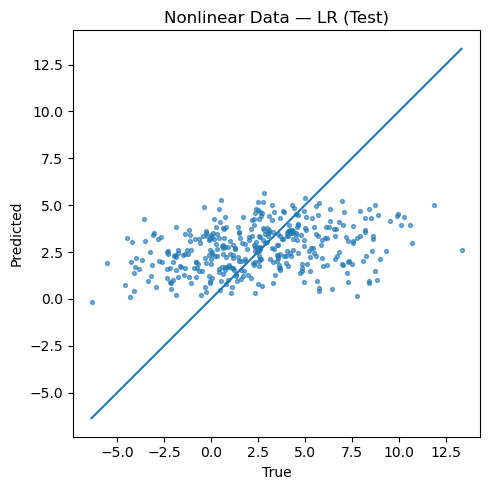

=== Nonlinear Data — Neural Network ===
Train R^2: 0.9489
Test  R^2: 0.9081
Train MAE: 0.6164
Test  MAE: 0.8668
Fit time: 809.4 ms


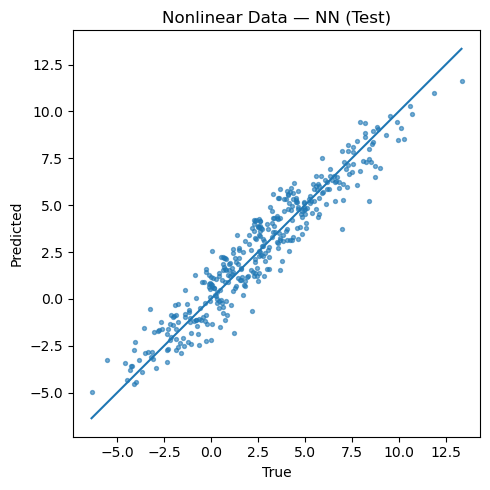

In [7]:
# Linear Regression
t0 = perf_counter()
lr_pipe.fit(Xtr_non, ytr_non)
t1 = perf_counter()
yhat_tr_lr = lr_pipe.predict(Xtr_non)
yhat_te_lr = lr_pipe.predict(Xte_non)
summarize(ytr_non, yhat_tr_lr, yte_non, yhat_te_lr, t1 - t0, "Nonlinear Data — Linear Regression")
plot_pred_vs_true(yte_non, yhat_te_lr, title="Nonlinear Data — LR (Test)")

# Neural Network
t0 = perf_counter()
nn_pipe.fit(Xtr_non, ytr_non)
t1 = perf_counter()
yhat_tr_nn = nn_pipe.predict(Xtr_non)
yhat_te_nn = nn_pipe.predict(Xte_non)
summarize(ytr_non, yhat_tr_nn, yte_non, yhat_te_nn, t1 - t0, "Nonlinear Data — Neural Network")
plot_pred_vs_true(yte_non, yhat_te_nn, title="Nonlinear Data — NN (Test)")

### Interpretability (Synthetic): LR Coefficients vs Permutation Importance

Linear Regression coefficients shape: (10,)
First 10 coefficients: [ 0.09   0.033  0.293  0.008  0.92  -0.736  0.069  0.041  0.002 -0.051]
Permutation importance on Nonlinear (test) — LR


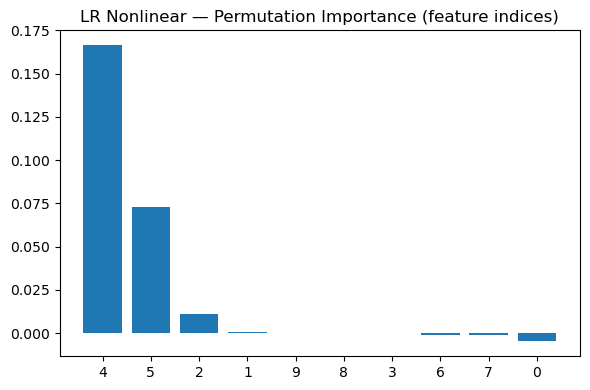

Permutation importance on Nonlinear (test) — NN


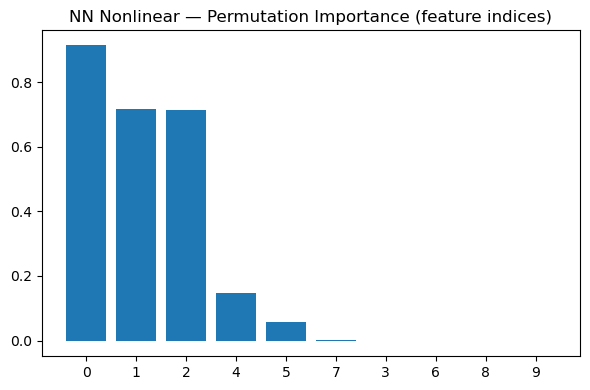

In [8]:
# For LR: coefficients (after scaling)
lr_model = lr_pipe.named_steps["model"]
print("Linear Regression coefficients shape:", lr_model.coef_.shape)
print("First 10 coefficients:", np.round(lr_model.coef_[:10], 3))

# Permutation importance (works for any model)
def show_permutation_importance(model, X, y, title):
    r = permutation_importance(model, X, y, n_repeats=10, random_state=RANDOM_SEED)
    idx = np.argsort(r.importances_mean)[::-1]
    plt.figure(figsize=(6,4))
    plt.bar(range(len(idx)), r.importances_mean[idx])
    plt.xticks(range(len(idx)), idx)
    plt.title(title + " — Permutation Importance (feature indices)")
    plt.tight_layout()
    plt.show()

print("Permutation importance on Nonlinear (test) — LR")
show_permutation_importance(lr_pipe, Xte_non, yte_non, "LR Nonlinear")

print("Permutation importance on Nonlinear (test) — NN")
show_permutation_importance(nn_pipe, Xte_non, yte_non, "NN Nonlinear")

## Real Data: California Housing

In [10]:
data_path = "data/california_housing.csv"  # change if needed
df = pd.read_csv(data_path)
print(df.head())
print(df.describe(include='all'))

   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  Price  
0    -122.23  4.526  
1    -122.22  3.585  
2    -122.24  3.521  
3    -122.25  3.413  
4    -122.25  3.422  
             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       3.870671     28.639486      5.429000      1.096675   1425.476744   
std        1.899822     12.585558      2.474173      0.473911   1132.462122   
min        0.499900      1.000000      0.846154      0.333333      3.000000   
25%        2.563

### Train/Test split

In [11]:
feature_cols = ["MedInc","HouseAge","AveRooms","AveBedrms","Population","AveOccup","Latitude","Longitude"]
target_col = "Price"

X = df[feature_cols].values
y = df[target_col].values

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
Xtr.shape, Xte.shape

((16512, 8), (4128, 8))

### Define pipeline

In [12]:
lr_real = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LinearRegression())
])

nn_real = Pipeline([
    ("scaler", StandardScaler()),
    ("model", MLPRegressor(hidden_layer_sizes=(128,64),
                           activation="relu",
                           solver="adam",
                           max_iter=3000,
                           random_state=RANDOM_SEED,
                           early_stopping=True,
                           n_iter_no_change=20,
                           validation_fraction=0.1))
])

### Train and Evaluate

=== California Housing — Linear Regression ===
Train R^2: 0.6126
Test  R^2: 0.5758
Train MAE: 0.5286
Test  MAE: 0.5332
Fit time: 10.7 ms


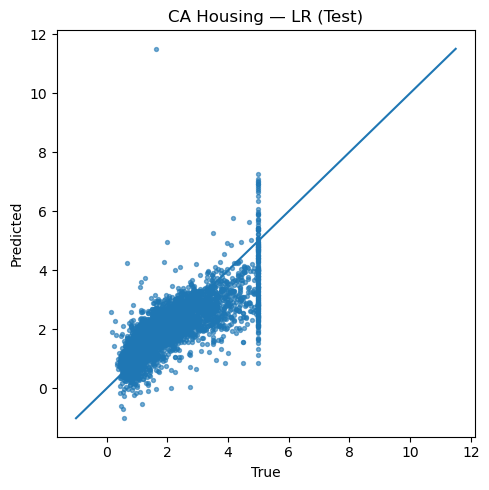

=== California Housing — Neural Network ===
Train R^2: 0.8247
Test  R^2: 0.7955
Train MAE: 0.3278
Test  MAE: 0.3484
Fit time: 9170.4 ms


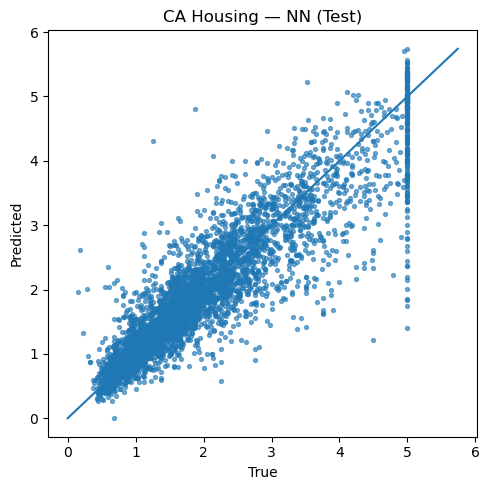

In [13]:
# Linear Regression
t0 = perf_counter()
lr_real.fit(Xtr, ytr)
t1 = perf_counter()
yhat_tr_lr = lr_real.predict(Xtr)
yhat_te_lr = lr_real.predict(Xte)
summarize(ytr, yhat_tr_lr, yte, yhat_te_lr, t1 - t0, "California Housing — Linear Regression")
plot_pred_vs_true(yte, yhat_te_lr, "CA Housing — LR (Test)")

# Neural Network
t0 = perf_counter()
nn_real.fit(Xtr, ytr)
t1 = perf_counter()
yhat_tr_nn = nn_real.predict(Xtr)
yhat_te_nn = nn_real.predict(Xte)
summarize(ytr, yhat_tr_nn, yte, yhat_te_nn, t1 - t0, "California Housing — Neural Network")
plot_pred_vs_true(yte, yhat_te_nn, "CA Housing — NN (Test)")

### Fold Cross-Validation

In [14]:
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

lr_cv = cross_val_score(lr_real, X, y, cv=cv, scoring="r2")
nn_cv = cross_val_score(nn_real, X, y, cv=cv, scoring="r2")

print("LR  CV R^2:", np.round(lr_cv, 4), "mean:", lr_cv.mean().round(4))
print("NN  CV R^2:", np.round(nn_cv, 4), "mean:", nn_cv.mean().round(4))

LR  CV R^2: [0.5758 0.6137 0.6086 0.6213 0.5875] mean: 0.6014
NN  CV R^2: [0.7965 0.7982 0.7967 0.8036 0.8043] mean: 0.7999


### Interpretability: Coefficients & Permutation Importance

    MedInc: +0.8544
  HouseAge: +0.1225
  AveRooms: -0.2944
 AveBedrms: +0.3393
Population: -0.0023
  AveOccup: -0.0408
  Latitude: -0.8969
 Longitude: -0.8698


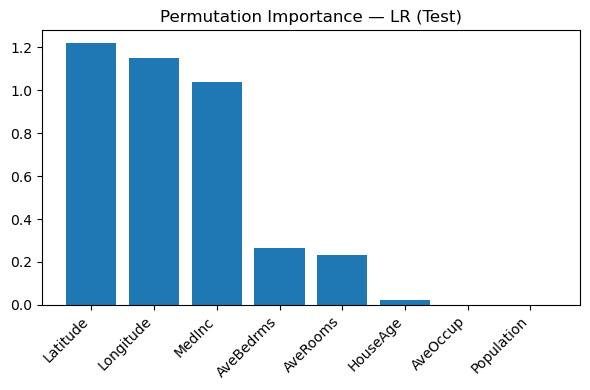

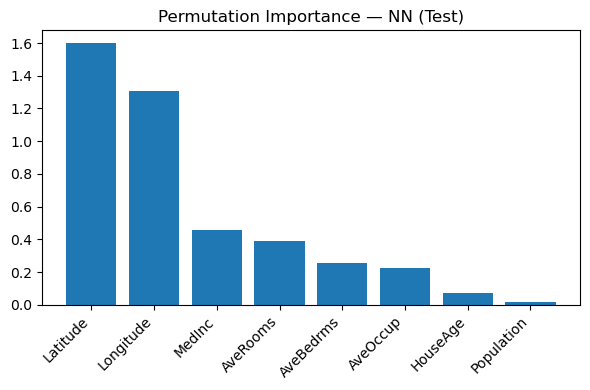

In [15]:
# Coefficients (after scaling)
coef = lr_real.named_steps["model"].coef_
for name, c in zip(feature_cols, coef):
    print(f"{name:>10s}: {c:+.4f}")

# Permutation importance on test split
r_lr = permutation_importance(lr_real, Xte, yte, n_repeats=10, random_state=RANDOM_SEED)
r_nn = permutation_importance(nn_real, Xte, yte, n_repeats=10, random_state=RANDOM_SEED)

def plot_perm(names, importances, title):
    order = np.argsort(importances)[::-1]
    plt.figure(figsize=(6,4))
    plt.bar(range(len(order)), importances[order])
    plt.xticks(range(len(order)), [names[i] for i in order], rotation=45, ha="right")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_perm(feature_cols, r_lr.importances_mean, "Permutation Importance — LR (Test)")
plot_perm(feature_cols, r_nn.importances_mean, "Permutation Importance — NN (Test)")

### Simple Training- Cost Sweep

In [17]:
sizes = [(32,), (64,), (128,), (128,64), (256,128)]
results = []

for hs in sizes:
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("model", MLPRegressor(hidden_layer_sizes=hs, activation="relu",
                               solver="adam", max_iter=2000,
                               random_state=RANDOM_SEED, early_stopping=True,
                               n_iter_no_change=15, validation_fraction=0.1))
    ])
    t0 = perf_counter()
    model.fit(Xtr, ytr)
    t1 = perf_counter()
    yhat = model.predict(Xte)
    results.append((hs, r2_score(yte, yhat), mean_absolute_error(yte, yhat), t1 - t0))

# Display
for hs, r2, mae, t in results:
    print(f"Hidden={str(hs):<12}  R^2={r2:.4f}  MAE={mae:.4f}  time={t:.2f}s")

Hidden=(32,)         R^2=0.7622  MAE=0.3774  time=6.97s
Hidden=(64,)         R^2=0.7664  MAE=0.3791  time=5.20s
Hidden=(128,)        R^2=0.7794  MAE=0.3653  time=10.80s
Hidden=(128, 64)     R^2=0.7955  MAE=0.3484  time=9.01s
Hidden=(256, 128)    R^2=0.7953  MAE=0.3437  time=13.56s


### What you should see (typical):
    • On LINEAR synthetic data: Linear Regression ≈ best generalization; NN can match but may be slower.
    • On NONLINEAR synthetic data: NN should outperform Linear Regression due to higher expressive power.
    • On California Housing: both work; NN often edges out LR slightly if tuned, at higher training cost.
    • Interpretability: LR has direct coefficients; NN needs model-agnostic tools (e.g., permutation importance).

